# Тимски проект: Споредба на алгоритмите за предвидување на временски серии
**Dataset:** PJME Hourly Energy Consumption

## 1. Вовед и опис на множеството
Во оваа тетратка се анализира часовната потрошувачка на електрична енергија користејќи го множеството податоци PJME Hourly Energy Consumption. Целта на анализата е да се предвиди идната побарувачка на електрична енергија и да се направи споредба помеѓу различни пристапи за предвидување.

Множеството податоци ги содржи следните променливи:

*   Datetime – временски ознаки во часови
*   PJME_MW – потрошувачка на електрична енергија изразена во мегавати (MW)

## 2. Вчитување и препроцесирање на податоците


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import xgboost as xgb

from prophet import Prophet

In [2]:
plt.rcParams['figure.figsize'] = (14,5)
np.random.seed(42)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/hourly-energy-consumption/PJME_hourly.csv')

In [5]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime').sort_index()

In [6]:
df.sample(10)

,PJME_MW
Datetime,
2017-12-11 08:00:00,36021.0
2008-08-13 20:00:00,40141.0
2011-01-10 06:00:00,35201.0
2003-12-09 23:00:00,34066.0
2004-12-29 02:00:00,29686.0
2015-03-02 05:00:00,31387.0
2007-11-17 14:00:00,30820.0
2014-01-22 13:00:00,43510.0
2013-12-31 10:00:00,35818.0


In [7]:
df.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


In [8]:
df.isna().sum()

,0
PJME_MW,0


## 3. Експлораторна анализа на податоците (EDA)

###Целосна временска серија

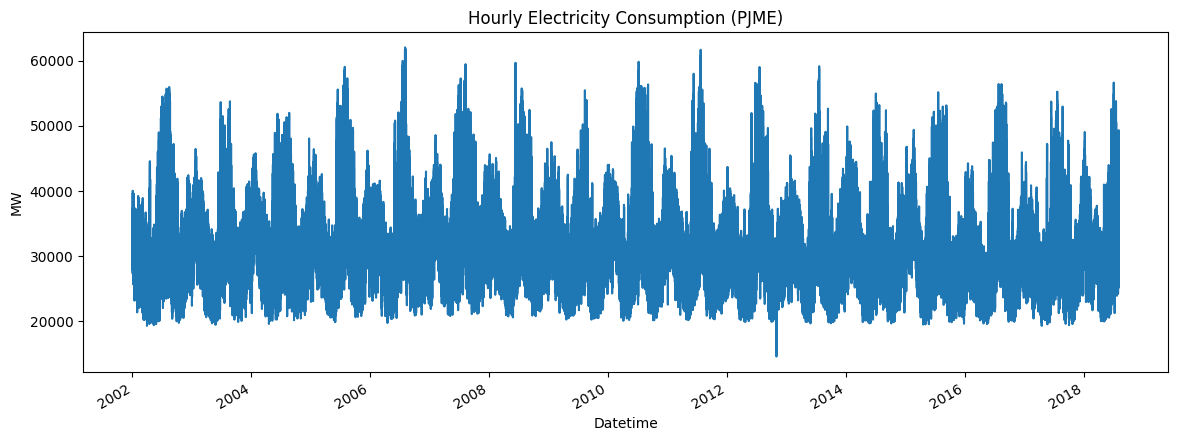

In [9]:
df['PJME_MW'].plot(title='Hourly Electricity Consumption (PJME)')
plt.ylabel('MW')
plt.show()

###Преглед на една недела

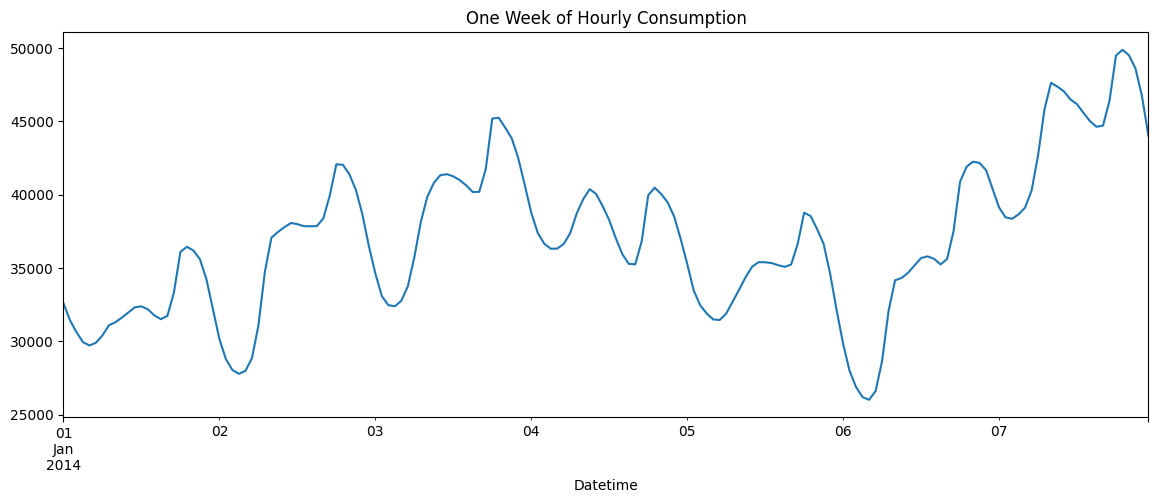

In [10]:
df.loc['2014-01-01':'2014-01-07', 'PJME_MW'].plot(title='One Week of Hourly Consumption')
plt.show()

###Просечна потрошувачка по час

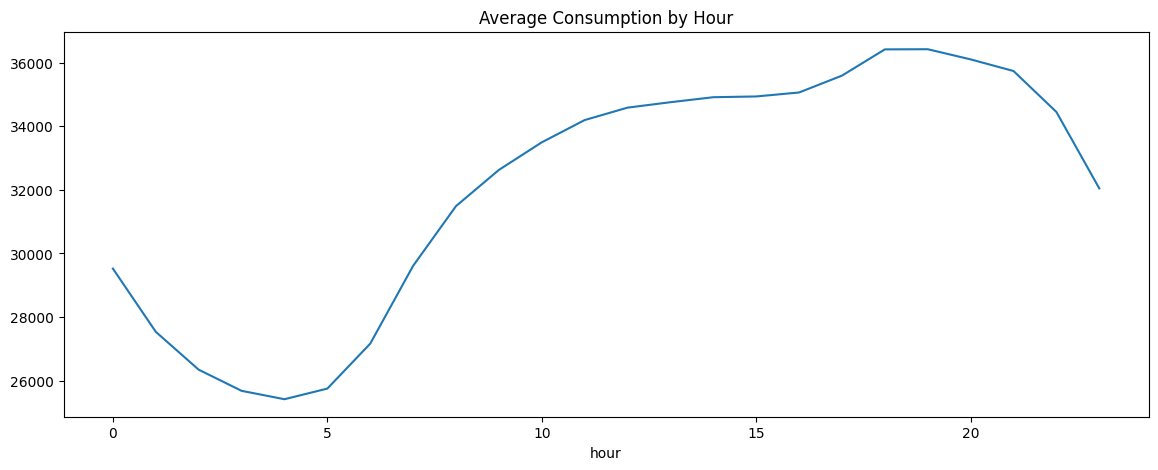

In [11]:
df['hour'] = df.index.hour
df.groupby('hour')['PJME_MW'].mean().plot(title='Average Consumption by Hour')
plt.show()

###Просечна потрошувачка по ден во неделата

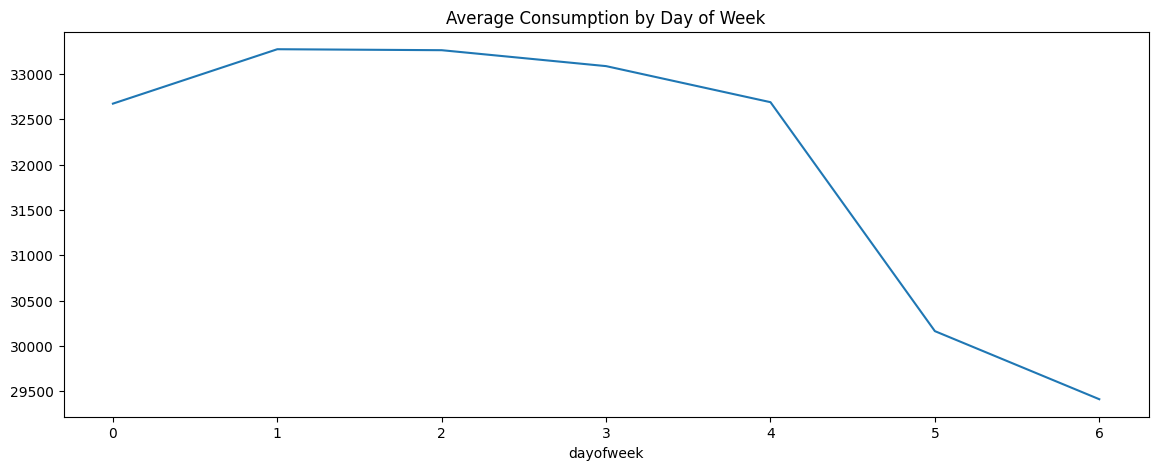

In [12]:
df['dayofweek'] = df.index.dayofweek
df.groupby('dayofweek')['PJME_MW'].mean().plot(title='Average Consumption by Day of Week')
plt.show()

###Просечна потрошувачка по месец

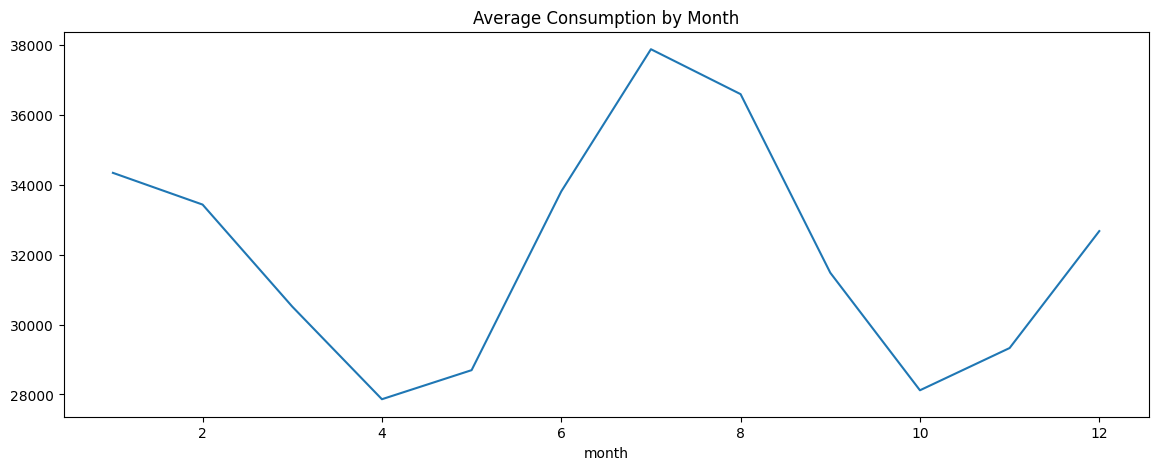

In [13]:
df['month'] = df.index.month
df.groupby('month')['PJME_MW'].mean().plot(title='Average Consumption by Month')
plt.show()

## 4. Декомпозиција на временската серија

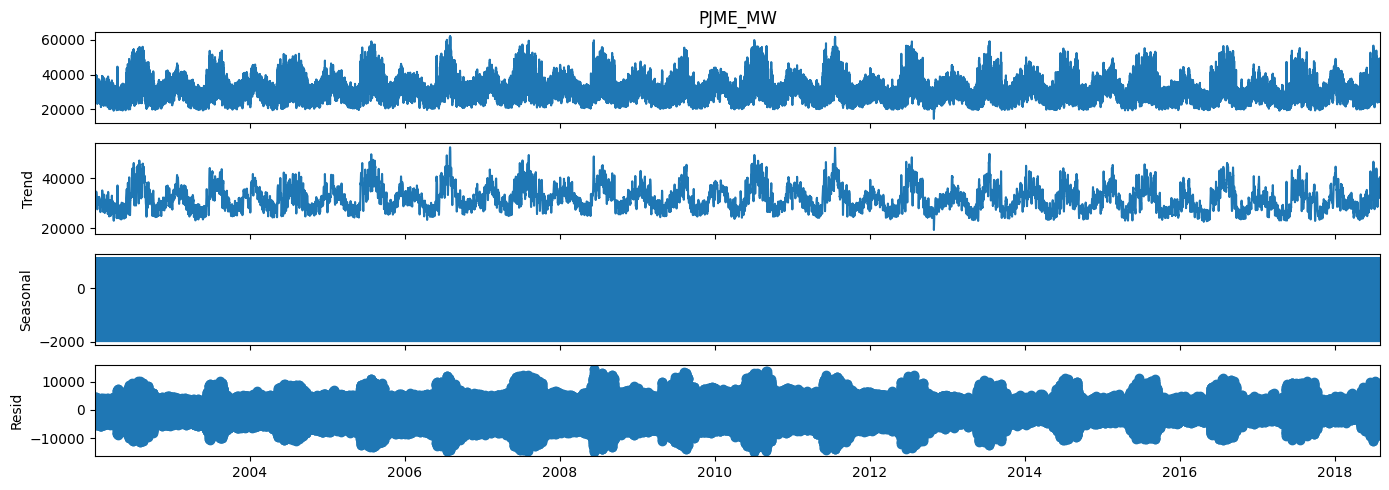

In [14]:
decomposition = seasonal_decompose(df['PJME_MW'], model='additive', period=24)
decomposition.plot()
plt.show()

## 5. Основни (Baseline) модели

Naïve Forecast (Lag-1)

In [17]:
df['lag_1'] = df['PJME_MW'].shift(1)

Seasonal Naïve Forecast (Lag-24)

In [18]:
df['lag_24'] = df['PJME_MW'].shift(24)

## 6. Класични модели (ARIMA и Prophet)

Train/Test Split

In [19]:
split_date = '2015-01-01'

train = df[df.index < split_date]
test  = df[df.index >= split_date]

ARIMA

In [20]:
arima_model = ARIMA(train['PJME_MW'], order=(1,0,1))
arima_fit = arima_model.fit()

arima_pred = arima_fit.forecast(steps=len(test))

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/pyth

####Prophet

In [21]:
prophet_df = train.reset_index()[['Datetime', 'PJME_MW']]
prophet_df.columns = ['ds', 'y']

prophet_model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True
)

In [22]:
prophet_model.fit(prophet_df)

future = prophet_model.make_future_dataframe(periods=len(test), freq='H')
forecast = prophet_model.predict(future)

prophet_pred = forecast.iloc[-len(test):]['yhat'].values

/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


## 7. Машинско учење

In [23]:
df['lag_1']   = df['PJME_MW'].shift(1)
df['lag_24']  = df['PJME_MW'].shift(24)
df['lag_168'] = df['PJME_MW'].shift(168)

In [24]:
df['rolling_mean_24'] = df['PJME_MW'].shift(1).rolling(24).mean()
df['rolling_std_24'] = df['PJME_MW'].shift(1).rolling(24).std()

In [25]:
df_ml = df.dropna()

In [26]:
print(len(test['PJME_MW']), len(df['lag_1'].dropna()))


31440 145365


In [27]:
train_ml = df_ml[df_ml.index < split_date]
test_ml = df_ml[df_ml.index >= split_date]

In [28]:
X_train = train_ml.drop(columns=['PJME_MW'])
y_train = train_ml['PJME_MW']
X_test = test_ml.drop(columns=['PJME_MW'])
y_test = test_ml['PJME_MW']

####XGBoost Model

In [29]:
xgb_model = xgb.XGBRegressor(
n_estimators=300,
learning_rate=0.05,
max_depth=6,
subsample=0.8,
colsample_bytree=0.8,
random_state=42
)

In [30]:
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

In [31]:
results = []

def evaluate(y_true, y_pred):
  return {
      'MAE': mean_absolute_error(y_true, y_pred),
      'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
      'R2': r2_score(y_true, y_pred)
  }

In [32]:
lag_1_pred = df['lag_1'].dropna()
common_idx = lag_1_pred.index.intersection(test.index)
lag_1_pred_aligned = lag_1_pred.loc[common_idx]
y_true_lag1_aligned = test['PJME_MW'].loc[common_idx]

results.append({'Model': 'Naive (Lag-1)', **evaluate(y_true_lag1_aligned, lag_1_pred_aligned)})

lag_24_pred = df['lag_24'].dropna()
common_idx24 = lag_24_pred.index.intersection(test.index)
lag_24_pred_aligned = lag_24_pred.loc[common_idx24]
y_true_lag24_aligned = test['PJME_MW'].loc[common_idx24]

In [33]:
#results.append({'Model': 'Naive (Lag-1)', **evaluate(test['PJME_MW'], df.loc[test.index, 'lag_1'])})
#results.append({'Model': 'Seasonal Naive (Lag-24)', **evaluate(test['PJME_MW'], df.loc[test.index, 'lag_24'])})
results.append({'Model': 'ARIMA', **evaluate(test['PJME_MW'], arima_pred)})
results.append({'Model': 'Prophet', **evaluate(test['PJME_MW'], prophet_pred)})
results.append({'Model': 'XGBoost', **evaluate(y_test, y_pred_xgb)})

In [34]:
results_df = pd.DataFrame(results)
results_df

,Model,MAE,RMSE,R2
0,Naive (Lag-1),1062.535655,1366.017831,0.955143
1,ARIMA,5255.467113,6521.815937,-0.022487
2,Prophet,3188.970107,4185.641501,0.578842
3,XGBoost,353.713118,467.856813,0.994738


###Actual vs Predicted Scatter Plot

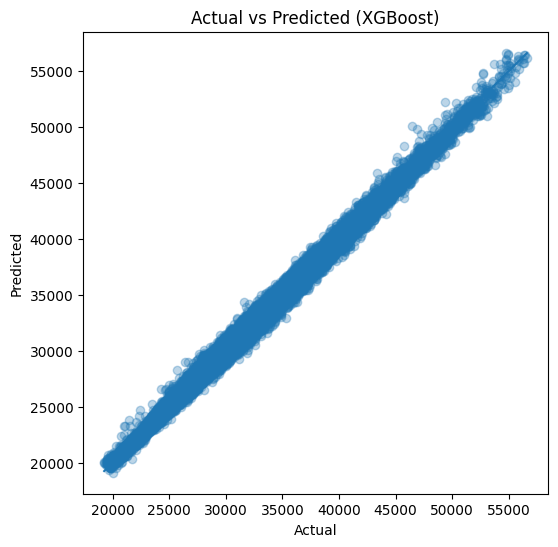

In [35]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_xgb, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (XGBoost)')
plt.show()

###Compare Model Errors

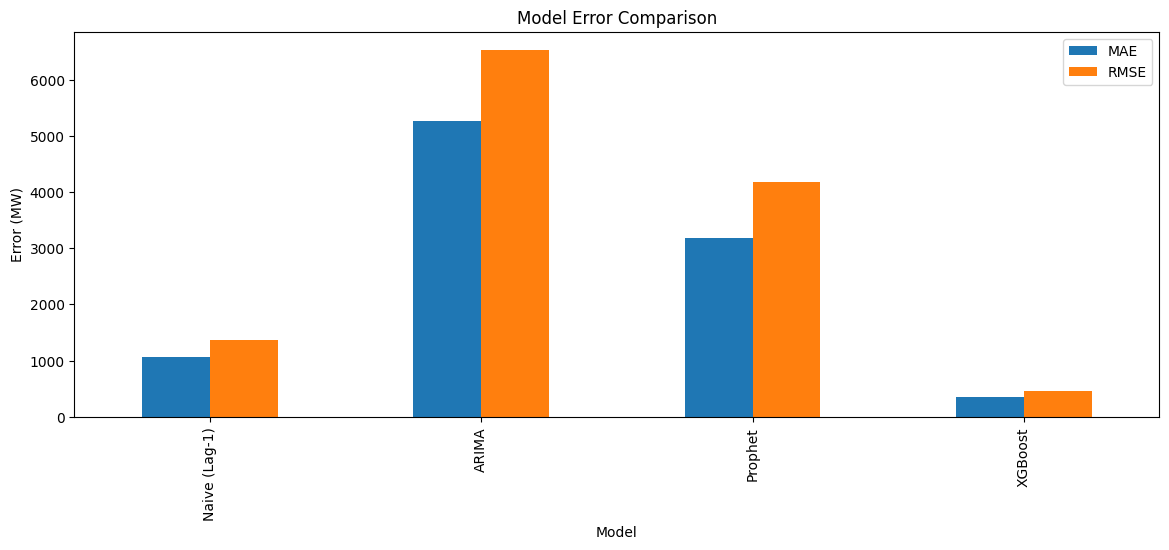

In [37]:
results_df.set_index('Model')[['MAE','RMSE']].plot(kind='bar')
plt.title('Model Error Comparison')
plt.ylabel('Error (MW)')
plt.show()